In [10]:
using Plots
using PlotlyJS
using Statistics
using QuadGK
using MAT

## constants

In [11]:
# physical constants
g = 9.81 # gravitational acceleration [m/s^2]

# fluid properties 
rho_a    = 1.225;     # Density of air [kg/m^3]
c_a      = 1005;      # Specific heat of air [J/KgK]

# building model properties
v_a      = 2880;     # Volume of air inside the building [m^3]
A_f     = 2*90;       # Area of the 3 floors [m^2]
th      = 0.1;       # Thickness of thermal mass floors[m]
E_int    = 250;      # Internal loads due to occupancy, lighting and equipment [W]

# material properties
rho_f   = 2300;     # Density of Thermal Mass concrete [kg/m^3]
k_f     = 0.8;         # Conductivity of Thermal Mass concrete [W/mK]
c_f     = 750;        # Specific heat of Thermal Mass concrete [J/KgK]
h  = 4;           # Convective heat coefficient [W/m2.K]

## functions

In [12]:

function conductionMatrix(lambda, dt, dx, Nx)
    """calculate temperature evolution within a fabric """
    A = zeros(Nx, Nx)

    A[1,1] = 1-lambda;  
    A[1,2] = lambda;
    A[Nx,Nx-1] = lambda;
    A[Nx,Nx] = 1-lambda;  
    
    # all other rows 
    for i = 2:Nx-1
        A[i, i-1] = lambda;
        A[i, i] = 1-2*lambda;
        A[i, i+1] = lambda;
    end

    return A

end

function cd_pivot(alpha)
    "calculate discharge coefficient based on window opening angle"
    W=1;
    H=1;
    W_pivot = z -> (1/W^2 + 1/(2*(H-z)*tand(alpha)+sind(alpha)*W).^2) .^(-1/2)
    h = H * (1- cosd(alpha));
    integral, est = quadgk(W_pivot,h,H) #rtol=1e-8 -> error when go to last element of angle array
    A_eff = W*h + integral ;
    Cd0 = 0.611;
    Cd = A_eff / (H*W) * Cd0;   
    
end

cd_pivot (generic function with 1 method)

## initialize variables for convective heat transfer calculation 

In [13]:
# Discrete variables for 1D conduction calculation over time => T(t+1,x) = A*T(t,x) + b
dt = 15;
dx = th/10;
x = range(0, th, step = dx)  |> collect 
Nx = length(x)

11

In [14]:
# initialize A matrix 
alpha = k_f/(rho_f*c_f) # thermal conductivity / (density * specific heat )
lambda = alpha * dt / dx^2 # this could all go into the matrix 
A = conductionMatrix(lambda, dt, dx, Nx);

In [71]:
A

11×11 Matrix{Float64}:
 0.930435   0.0695652  0.0        …  0.0        0.0        0.0
 0.0695652  0.86087    0.0695652     0.0        0.0        0.0
 0.0        0.0695652  0.86087       0.0        0.0        0.0
 0.0        0.0        0.0695652     0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0695652  0.0        0.0
 0.0        0.0        0.0           0.86087    0.0695652  0.0
 0.0        0.0        0.0           0.0695652  0.86087    0.0695652
 0.0        0.0        0.0        …  0.0        0.0695652  0.930435

In [15]:
# initialize T_f matrix
# T_f => [x * t]

## initialize variables for natural ventilation calculation

In [59]:
# window properties 
w1 = Dict("alpha" => 42, "area" => 1.61, "l" => 11.34)
w1["cd"] = cd_pivot(w1["alpha"])

w2 = Dict("alpha" => 42, "area" => 1.755, "l" => 6.62)
w2["cd"] = cd_pivot(w2["alpha"])

w3 = Dict("alpha" => 42, "area" => 1.755, "l" => 2.07)
w3["cd"] = cd_pivot(w3["alpha"]);

In [94]:
function init_arrays()
    # missing variables -> based on actual data! (do dummy first though )
    time = range(0, dt*20, step = dt)
    to_Kelvin = 273.5
    T_in_meas = sind.(time) .+ to_Kelvin
    T_out_meas_meas = T_in_meas .- (sind.(time.* 0.1)) .- 0.1 

    # values to calculate 
    T_in = zeros(length(time))
    T_f = zeros(length(x),length(time));

    # values to
    T_in[1] = T_in_meas[1];  # interior starts at the fabric?
    T_f[:,1] .= 280;
    # TODO -> issue fabric and calculated interior air temperature cant be initialized to equal each other if they are being subtracted to determine the convective heat flux??

    Q1 = zeros(length(time));
    Q2 = zeros(length(time));
    Q3 = zeros(length(time));
    Q_tot = zeros(length(time));
    E_nv = zeros(length(time));
    E_convst = zeros(length(time));
    b = zeros(1,Nx)
    Eist = zeros(length(time));

    

end

init_arrays (generic function with 1 method)

In [84]:
T_f

11×21 Matrix{Float64}:
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

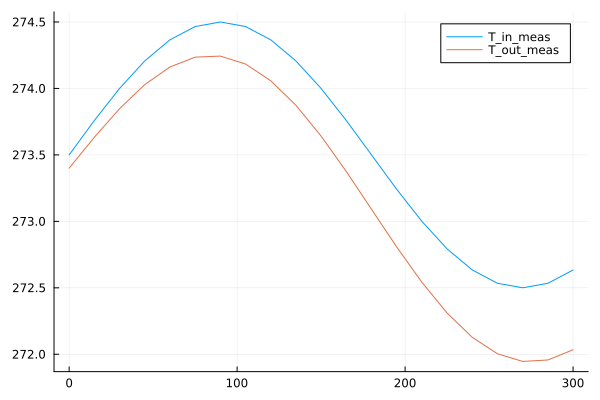

In [54]:
Plots.plot(time, T_in_meas, label="T_in_meas")
Plots.plot!(time, T_out_meas, label="T_out_meas")

In [96]:
init_arrays()

21-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [104]:
time = range(0, dt*20, step = dt)
to_Kelvin = 273.5
T_in_meas = sind.(time) .+ to_Kelvin
T_out_meas_meas = T_in_meas .- (sind.(time.* 0.1)) .- 0.1 

# values to calculate 
T_in = zeros(length(time))
T_f = zeros(length(x),length(time));

# values to
T_in[1] = T_in_meas[1];  # interior starts at the fabric?
T_f[:,1] .= 280;
# TODO -> issue fabric and calculated interior air temperature cant be initialized to equal each other if they are being subtracted to determine the convective heat flux??

Q1 = zeros(length(time));
Q2 = zeros(length(time));
Q3 = zeros(length(time));
Q_tot = zeros(length(time));
E_nv = zeros(length(time));
E_convst = zeros(length(time));
b = zeros(1,Nx)
Eist = zeros(length(time));

In [105]:
T_f

11×21 Matrix{Float64}:
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 280.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## dynamic thermal model

In [100]:


for t=1:length(time)-1

    # calculate E_nv at each time step 
    # TODO make function that calculates E_nv, how was this done before we knew outside vs inside?
    for (w, Q) in zip([w1, w2, w3], [Q1, Q2, Q3]) 
        
        # TODO adjust this to comsider wind ventilation, in addition to buoyancy 
        Q[t] = w["cd"] * w["area"] * sqrt(2*g*w["l"] * (T_in_meas[t]-T_out_meas[t]) /(T_out_meas[t]))
    end
    Q_tot[t] = Q1[t] + Q2[t] + Q3[t]
    E_nv[t] = rho_a * c_a * Q_tot[t] * (T_out_meas[t] - T_in[t])


    # calculate E_conv at each time step 
    E_conv = h * A_f * (T_f[1,t] - T_in[t]) # TODO multiply by number of surfaces being considered
    # print("T_f[1,t] $(T_f[1,t]) , T_in[t] $(T_in[t]) \n")
    E_convst[t] =  E_conv # guessing this is holding the variable?

    # # wall boundary conditions 
    # initialize the b matrix, this likely is related to the boundary conditions somehow..
    b[1] = - lambda * dx / (k_f * E_conv)
    b[Nx] = - lambda * dx / (k_f * E_conv)
    # print("b $b, time $t \n")

    # calculate surface temperature at each time step
    T_f[:, t+1] = A*T_f[:,t] + b'

    # calculate interior average air temperaure at each time step 
    T_in[t + 1] = T_in[t] + (E_conv * A_f + E_int + E_nv[t]) * dt/(v_a * rho_a * c_a)
    Eist[t] = E_int # what does this do///


 end

In [106]:
A

11×11 Matrix{Float64}:
 0.930435   0.0695652  0.0        …  0.0        0.0        0.0
 0.0695652  0.86087    0.0695652     0.0        0.0        0.0
 0.0        0.0695652  0.86087       0.0        0.0        0.0
 0.0        0.0        0.0695652     0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0695652  0.0        0.0
 0.0        0.0        0.0           0.86087    0.0695652  0.0
 0.0        0.0        0.0           0.0695652  0.86087    0.0695652
 0.0        0.0        0.0        …  0.0        0.0695652  0.930435

In [103]:
T_f

11×21 Matrix{Float64}:
 280.0  280.0  280.0  280.0  280.0  …  280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0  …  280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0     280.0  280.0  280.0  280.0  280.0
 280.0  280.0  280.0  280.0  280.0  …  280.0  280.0  280.0  280.0  280.0

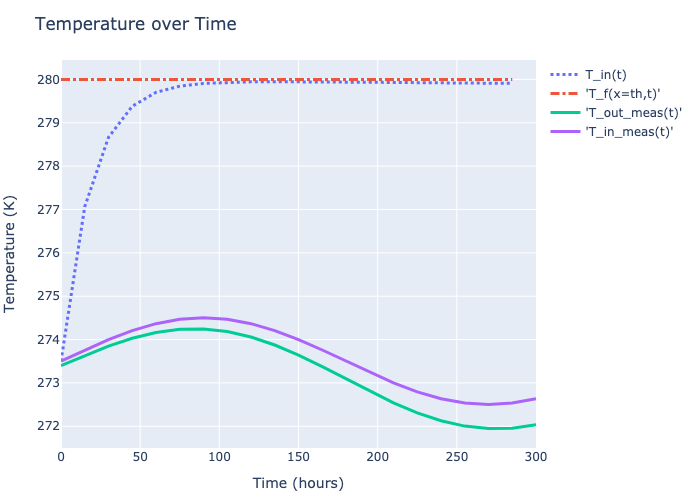

In [102]:
labels = ["T_in(t)","'T_f(x=th,t)'","'T_out_meas(t)'","'T_in_meas(t)'"];
vals = [T_in[1:end-1], T_f[end, 1:end-1], T_out_meas, T_in_meas]
linewidths = [3,3,3,3]
dashtypes = ["dot", "dashdot", "none", "none"]


traces = [PlotlyJS.scatter(x=vec(time),  y=val, mode="lines", name=label, line=attr(width=lw, dash=dt)) for (val,label, lw, dt) in zip(vals, labels, linewidths, dashtypes)];


p3 = PlotlyJS.plot(traces, Layout(;title="Temperature over Time", showlegend=true, xaxis_title="Time (hours)", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=false));
p3